<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/Dendric-spikes/Stylized_Reduced_Order_L5_dendritic_spiking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Neuron Initialization
Import modules and setup simulation parameters

In [ ]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Stylized-Cell-model/

/content/drive/MyDrive/Stylized-Cell-model


In [ ]:
#import os
#%cd mechanisms/
#os.system('nrnivmodl')
#%cd ..

In [ ]:
from neuron import h
import pandas as pd
import numpy as np
import os
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_standard.csv'
tstop = 500  # ms
dt = 0.025  # ms. does not allow change

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

In [ ]:
#pick a random seed to initalize random values
import random
random.seed(442022)


In [ ]:
pi=np.pi
#calculate locations of synapses normally distributed
syn_exc_number = np.int_(2.16*200) # number of synapses = density (syn/um) times length of dendrites (um)
syn_inh_number = np.int_(.22*200)
syn_number = syn_inh_number + syn_exc_number # total number of synapses
#syn_dist = np.random.rand(syn_number) #length proportionate(0 to 1) location of synapses by random distribution from 0-1 of integer number of synapses

#randomly assign synapse type by proportion;
#sec_index_list = list(range(1,9)) #list dendrites
#rand_syntype = np.random.rand(syn_number) #generate a new random set of numbers from 0-1
#prop_exc = syn_exc_number/syn_number
#syn_type_list = ['exc' if y<prop_exc else
#                 'inh' for y in rand_syntype]

In [ ]:
#def lognormal(m, s):
#        mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
#        std = np.sqrt(np.log((s/m)**2 + 1))
#        #import pdb; pdb.set_trace()
#        return max(np.random.lognormal(mean, std, 1), 0.00000001)
#lognormal() mean = 0.2 nS, std = 0.345 nS
#generators = []

Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

In [ ]:
class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,biophys=None,dL=30,vrest=-72.0):
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        biophys: vector of biophysical parameters corresponding to "biophys_entries". Use -1 for default value.
        dL: maximum segment length
        vrest: reversal potential for leak channels
        """
        self.biophys = biophys
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
    
    def set_channels(self):
        """Define biophysical properties, insert channels"""
        self.define_biophys_entries()
        # common parameters
        for sec in self.all:
            sec.cm = 2.0
            sec.Ra = 100
            sec.insert('pas')
            sec.e_pas = self._vrest
        # fixed parameters
        soma = self.soma
        soma.cm = 1.0
        soma.insert('NaTa_t')  # Sodium channel
        soma.insert('SKv3_1')  # Potassium channel
        soma.insert('Ca_HVA')
        soma.insert('Ca_LVAst')
        soma.insert('CaDynamics_E2')
        soma.insert('Ih')
        soma.insert('SK_E2')
        soma.insert('K_Tst')
        soma.insert('K_Pst')
        soma.insert('Nap_Et2')
        soma.ena = 50
        soma.ek = -85
        for isec in self.grp_ids[2]:
            sec = self.get_sec_by_id(isec)  # apical dendrites
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85
        for isec in self.grp_ids[1]:
            sec = self.get_sec_by_id(isec)  # apical dendrites
            sec.insert('Ih')
        # variable parameters
        for i,entry in enumerate(self.biophys_entries):
            for sec in self.get_sec_by_id(self.grp_ids[entry[0]]):
                setattr(sec,entry[1],self.biophys[i])
        h.v_init = self._vrest
    

    def define_biophys_entries(self):
        """
        Define list of entries of biophysical parameters.
        Each entry is a pair of group id and parameter reference string.
        Define default values and set parameters in "biophys".
        """
        self.grp_sec_type_ids = [[0],[1,2],[3,4]]  # select section id's for each group
        self.grp_ids = []  # get indices of sections for each group
        for ids in self.grp_sec_type_ids:
            secs = []
            for i in ids:
                secs.extend(self.sec_id_lookup[i])
            self.grp_ids.append(secs)
        self.biophys_entries = [
            (0,'g_pas'),(1,'g_pas'),(2,'g_pas'),  # g_pas of soma, basal, apical 
            (0,'gNaTa_tbar_NaTa_t'),(2,'gNaTa_tbar_NaTa_t'),  # gNaTa_t of soma, apical 
            (0,'gSKv3_1bar_SKv3_1'),(2,'gSKv3_1bar_SKv3_1'),  # gSKv3_1 of soma, apical
            (0, 'gCa_HVAbar_Ca_HVA'),(2, 'gCa_HVAbar_Ca_HVA'),  # gCA_HVA of soma, apical
            (0, 'gCa_LVAstbar_Ca_LVAst'),(2, 'gCa_LVAstbar_Ca_LVAst'), # gCA_LVAst of soma, apical
            (2, 'gImbar_Im'), #gIm of apical
            (0,'decay_CaDynamics_E2'),(2,'decay_CaDynamics_E2'), #decay_CaDynamics of soma, apical
            (0,'gamma_CaDynamics_E2'),(2,'gamma_CaDynamics_E2'), #gamma_CaDynamics of soma, apical
            (0,'gIhbar_Ih'),(1,'gIhbar_Ih'),(2,'gIhbar_Ih'), #gIh of soma, apical
            (0,'gSK_E2bar_SK_E2'),(2,'gSK_E2bar_SK_E2'),
            (0,'gK_Tstbar_K_Tst'),
            (0,'gK_Pstbar_K_Pst'),
            (0,'gNap_Et2bar_Nap_Et2')
        ]

        default_biophys = np.array([3.26e-05,6.31e-05,8.82e-05, ## g_pas of soma, basal, apical
                                    2.43, 0.0252, # gNaTa_t
                                    0.983,0.0112, # gSKv3_1
                                    0.000642,0.00452, # gCA_HVA
                                    0.00462,0.104, # CA_LVAst
                                    0.000179, # Im
                                    770.0,133.0, # decay_CaDynamics_E2
                                    0.000616,0.0005, # gamma_CaDynamics_E2
                                    8e-05,0.0002,0.0002, #Ih
                                    0.0492, 0.0034, #SK_E2
                                    0.0471, #K_Tst
                                    0.000, #K_Pst
                                    0.00499 #Nap_Et2
                                    ])
        if self.biophys is not None:
            for i in range(len(self.biophys)):
                if self.biophys[i]>=0:
                    default_biophys[i]=self.biophys[i]
        self.biophys = default_biophys
    
    def add_synapse(self,stim,sec_index,**kwargs):
        """Add synapse to a section by its index"""
        self.injection.append(Synapse(self,stim,sec_index,**kwargs))
        
    
    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):

            return self.v_rec.as_numpy()

class Synapse(Point_current):
    def __init__(self,cell,stim,sec_index,gmaxEXC=0.01,gmaxINH=0.01,loc=0.5,record=True, SynType='exc'): 
        super().__init__(cell,sec_index,loc)
        self.stim = stim
        self.gmaxEXC = gmaxEXC
        self.gmaxINH = gmaxINH
        self.syntype = SynType
        self.setup(record,loc)

        

    def setup(self,record,loc):
        self.setup_synapse(loc)
        if record:
            self.setup_recorder()
    
    def setup_synapse(self,loc): 
        if self.syntype == 'inh':
          self.pp_obj = h.int2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = 0.6
          syn.initW = 0.5 #10 #.05
          self.nc = h.NetCon(self.stim,syn,1,0,1)

        else:
          self.pp_obj = h.pyr2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = 0.6
          syn.initW = 0.5
          self.nc = h.NetCon(self.stim,syn,1,0,1)

class Simulation(object):
    def __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],geo_param=[-1],biophys=[-1],gmaxEXC=0.015,gmaxINH=0.015,scale=1.0,ncell=1): #initially __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],geo_param=[-1],biophys=[-1],gmax=0.015,scale=1.0,ncell=1):
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        loc_param: location parameters, ncell-by-6 array, (x,y,z,theta,h,phi)
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        biophys: biophysical parameters, ncell-by-k array, if not specified, use default properties
        gmax: maximum conductance of synapse, ncell-vector, if is single value, is constant for all cells
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        ncell: number of cells in the simulation, required if simulating for multiple cells
        """
        self.ncell = ncell  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.set_loc_param(loc_param)
        self.set_geo_param(geo_param)
        self.set_biophys(biophys)
        self.set_gmax(gmaxEXC, gmaxINH)
        self.set_scale(scale)
        self.set_netstim()
        self.create_cells()  # create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time



    def set_netstim(self):
        """Setup synaptic input event"""
        stim_list = []
        self.stim = stim_list
        for i in range(syn_number):
          stim = h.NetStim()
          stim.number = 2  # average number of spikes
          stim.start = 50  #  most likely start time of first spike
          stim.noise = 1  # fractional randomness
          stim.interval = 1000  # mean time between spikes (ms)
          #duration of stimulation = stim.interval X stim.number
          stim_list.append(stim)


    
    def pack_parameters(self,param,ndim,param_name):
        """Pack parameters for the simulation"""
        if ndim==0:
            if not hasattr(param,'__len__'):
                param = [param]
            param = np.array(param).ravel()
            if param.size!=self.ncell:
                if param.size==1:
                    param = np.broadcast_to(param,self.ncell)
                else:
                    raise ValueError(param_name+" size does not match ncell")   
        if ndim==1:
            param = np.array(param)
            if param.ndim==1:
                param = np.expand_dims(param,0)
            if param.shape[0]!=self.ncell:
                if param.shape[0]==1:
                    param = np.broadcast_to(param,(self.ncell,param.shape[1]))
                else:
                    raise ValueError(param_name+" number of rows does not match ncell")
        return param
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-6 array"""
        loc_param = self.pack_parameters(loc_param,1,"loc_param")
        self.loc_param = [(loc_param[i,:3],loc_param[i,3:]) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.geo_param = self.pack_parameters(geo_param,1,"geo_param")
    
    def set_biophys(self,biophys):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.biophys = self.pack_parameters(biophys,1,"biophys")
    
    def set_gmax(self,gmaxEXC,gmaxINH):
        """Setup maximum conductance of synapse"""
        self.gmaxEXC = self.pack_parameters(gmaxEXC,0,"gmaxEXC")
        self.gmaxINH = self.pack_parameters(gmaxINH,0,"gmaxINH")
    
    def set_scale(self,scale):
        """setup scaling factors of lfp magnitude"""
        self.scale = self.pack_parameters(scale,0,"scale")
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            (0,'R'),  # change soma radius
            (3,'L'),  # change trunk length
            (3,'R'),  # change trunk radius
            ([1,2],'R'),  # change basal dendrites radius
            (4,'R'),  # change tuft radius
            ([1,2,4],'L') # change all dendrites length
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom



    def create_cells(self):
        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        # Create cell with morphology and biophysical parameters
        for i in range(self.ncell):
            geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
            self.cells.append( Cell(geometry=geometry,biophys=self.biophys[i,:]) )
        # add injection current or synaptic current and set up lfp recording
        min_dist = 10.0 # minimum distance allowed between segment and electrode. Set to None if not using.


############################################################################################################################################

        #get sec index for dendrites, comment section to remove synapses       
        sec_index_list = [] #basal:(1,4), apical:(5,9), tuft:(10,14)
        self.sec_index_list = sec_index_list

        apical_sec_list = list(range(1,5)) # apical indices 1,2,3,4
        #for index in apical_sec_list:
          #sec_index_list.append(index)
        for i,cell in enumerate(self.cells):
            # Synpatic input
            for k in range(len(apical_sec_list)):
              #stim_list = set_netstim()
              syn_dist = np.random.rand(syn_number)
              rand_syntype = np.random.rand(syn_number) #generate a new random set of numbers from 0-1
              prop_exc = syn_exc_number/syn_number
              syn_type_list = ['exc' if y<prop_exc else
                 'inh' for y in rand_syntype]
              for j in range(syn_number):
                cell.add_synapse(stim=self.stim[j],sec_index=apical_sec_list[k],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j])

        basal_sec_list = list(range(5,9)) # basal indices 5,6,7,8
#        for index in basal_sec_list:
#          sec_index_list.append(index)
        for i,cell in enumerate(self.cells):
            # Synpatic input
            for k in range(len(basal_sec_list)):
              #stim_list = set_netstim()
              syn_dist = np.random.rand(syn_number)
              rand_syntype = np.random.rand(syn_number) #generate a new random set of numbers from 0-1
              prop_exc = syn_exc_number/syn_number
              syn_type_list = ['exc' if y<prop_exc else
                 'inh' for y in rand_syntype]
              for j in range(syn_number):
                cell.add_synapse(stim=self.stim[j],sec_index=basal_sec_list[k],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j])

        tuft_sec_list = list(range(10,14)) # tuft indices 10,11,12,13
#        for index in tuft_sec_list:
#          sec_index_list.append(index)
        for i,cell in enumerate(self.cells):
            # Synpatic input
            for k in range(len(tuft_sec_list)):
              #stim_list = set_netstim()
              syn_dist = np.random.rand(syn_number)
              rand_syntype = np.random.rand(syn_number) #generate a new random set of numbers from 0-1
              prop_exc = syn_exc_number/syn_number
              syn_type_list = ['exc' if y<prop_exc else
                 'inh' for y in rand_syntype]
              for j in range(syn_number):
                cell.add_synapse(stim=self.stim[j],sec_index=tuft_sec_list[k],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j])


#        for i,cell in enumerate(self.cells):
            # Synpatic input
#            for k in range(len(sec_index_list)):
#              #stim_list = set_netstim()
#              syn_dist = np.random.rand(syn_number)
#              rand_syntype = np.random.rand(syn_number) #generate a new random set of numbers from 0-1
#              prop_exc = syn_exc_number/syn_number
#              syn_type_list = ['exc' if y<prop_exc else
#                 'inh' for y in rand_syntype]
#              for j in range(syn_number):
#                cell.add_synapse(stim=self.stim[j],sec_index=self.sec_index_list[k],gmaxEXC=self.gmaxEXC,gmaxINH=self.gmaxINH,loc=syn_dist[j],SynType=syn_type_list[j])

              
##############################################################################################################################################

            # Move cell location
            self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index (indices), (cells-by-)channels-by-time"""
        if not hasattr(index,'__len__'):
            lfp = self.lfp[index].calc_ecp()
        else:
            index = np.asarray(index).ravel()
            lfp = np.stack([self.lfp[i].calc_ecp() for i in index],axis=0)
        return lfp

#### Create simulation

In [ ]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [ ]:
loc_param = [50,0,10,0,1,0]  # example position #D: initially this was [0,0,50,0.2,0.75,1.5], (x,y,z,theta,h,phi), h=[-1,1] phi=[-pi,pi] h=.7071067812 for 90 deg
#note on parameters: Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate arccos(h) about x-axis (elevation), then rotate phi about y axis (azimuth).

geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
biophys = [3.26e-05,6.31e-05,8.82e-05, ## g_pas of soma, basal, apical 3.26e-05,6.31e-05,8.82e-05,
                                    2.43, 0.0252, # gNaTa_t 2.43, 0.0252
                                    0.983,0.0112, # gSKv3_1 0.983,0.0112
                                    0.000642,0.00452, # gCA_HVA 0.000642,0.00452,
                                    0.00462,0.104, # CA_LVAst 0.00462,0.104,
                                    0.0004, # Im 0.0004,
                                    770.0,133.0, # decay_CaDynamics_E2 770.0,133.0,
                                    0.000616,0.0005, # gamma_CaDynamics_E2 0.000616,0.0005,
                                    8e-05,0.0002,0.0002, #Ih 8e-05,0.0002,0.0002,
                                    0.0492, 0.0034, #SK_E2 0.0492, 0.0034,
                                    0.0471, #K_Tst 0.0471,
                                    0.000, #K_Pst 0.000,
                                    0.00499 #Nap_Et2 0.00499
                                    ]
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmaxEXC=0.000006,gmaxINH=0.000006,scale=100.)  # 0.001 -0.012 #gmax=.005, scale=100

Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [ ]:
seg_list = sim.cells[0].get_seg_by_id(range(1,99))

Vrecord = []
for i in range(0,len(seg_list)):
     Vrecord.append(seg_list[i])

dend_v = Recorder(Vrecord)





In [ ]:
def returnSegmentValues(section):
    #Set impedance measurement location and frequency
   
    zz = h.Impedance()
    zz.loc(sim.cells[0].get_sec_by_id([0])[0](0.5))
    zz.compute(25)

    # Get section 3d coordinates and put in numpy array
    n3d = section.n3d()
    x3d = np.empty(n3d)
    y3d = np.empty(n3d)
    z3d = np.empty(n3d)
    L = np.empty(n3d)
    for i in range(n3d):
        x3d[i]=section.x3d(i)
        y3d[i]=section.y3d(i)
        z3d[i]=section.z3d(i)

    # Compute length of each 3d segment
    for i in range(n3d):
        if i==0:
            L[i]=0
        else:
            L[i]=np.sqrt((x3d[i]-x3d[i-1])**2 + (y3d[i]-y3d[i-1])**2 + (z3d[i]-z3d[i-1])**2)

    # Get cumulative length of 3d segments
    cumLength = np.cumsum(L)
    N = section.nseg
    
    # Now upsample coordinates to segment locations
    xCoord = np.empty(N)
    yCoord = np.empty(N)
    zCoord = np.empty(N)
    Elec_distance = np.empty(N)

    dx = section.L / (N-1)
    for n in range(N):
        Elec_distance[n] = zz.ratio(section((n*dx)/cumLength[1]))
        if n==N-1: 
            xCoord[n]=x3d[-1]
            yCoord[n]=y3d[-1]
            zCoord[n]=z3d[-1]
        else:
            cIdxStart = np.where(n*dx >= cumLength)[0][-1] # which idx of 3d segments are we starting at
            cDistFrom3dStart = n*dx - cumLength[cIdxStart] # how far along that segment is this upsampled coordinate
            cFraction3dLength = cDistFrom3dStart / L[cIdxStart+1] # what's the fractional distance along this 3d segment
            # compute x and y positions
            xCoord[n] = x3d[cIdxStart] + cFraction3dLength*(x3d[cIdxStart+1] - x3d[cIdxStart])
            yCoord[n] = y3d[cIdxStart] + cFraction3dLength*(y3d[cIdxStart+1] - y3d[cIdxStart])
            zCoord[n] = z3d[cIdxStart] + cFraction3dLength*(z3d[cIdxStart+1] - z3d[cIdxStart])
            
    return xCoord, yCoord, zCoord, Elec_distance

In [ ]:
sec_list = sim.cells[0].get_sec_by_id(range(0,14))

SectionXCoord = []
SectionYCoord = []
SectionZCoord = []
SectionElecDist = []
AllSegXCoord = []
AllSegYCoord = []
AllSegZCoord = []
AllSegElecDist = []
for i in range(1,len(sec_list)):
  SectionXCoord, SectionYCoord, SectionZCoord, SectionElecDist = returnSegmentValues(sec_list[i])
  AllSegXCoord.extend(SectionXCoord)
  AllSegYCoord.extend(SectionYCoord)
  AllSegZCoord.extend(SectionZCoord)
  AllSegElecDist.extend(SectionElecDist)






In [ ]:
print(Vrecord)

[basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), basal(0.0714286), basal(0.214286), basal(0.357143), basal(0.5), basal(0.642857), basal(0.785714), basal(0.928571), apical(0.0714286), apical(0.214286), apical(0.357143), apical(0.5), apical(0.642857), apical(0.785714), apical(0.928571), apical(0.0714286), apical(0.214286), apical(0.357143), apical(0.5), apical(0.642857), apical(0.785714), apical(0.928571), apical(0.0714286), apical(0.214286), apical(0.357143), apical(0.5), apical(0.642857), apical(0.785714), apical(0.928571), apical(0.0714286), apical(0.214286), apical(0.357143), apical(0.5), apical(0.642857), apical(0.785714), apical(0.928571), trunk(0.0357143), trunk(0.107143), trunk(0.178571),

In [ ]:
ina = Recorder(obj_list = sim.cells[0].get_seg_by_id(70), var_name = 'ina')

In [ ]:
ical = Recorder(obj_list = sim.cells[0].get_seg_by_id(70), var_name = 'ica_Ca_LVAst')
icah = Recorder(obj_list = sim.cells[0].get_seg_by_id(70), var_name = 'ica_Ca_HVA')

In [ ]:
ih = Recorder(obj_list = sim.cells[0].segments, var_name = 'ihcn_Ih')

In [ ]:
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

In [ ]:
numSyn = len(sim.cells[0].injection)
numSeg = 99
numTstep = len(sim.cells[0].injection[0].rec_vec.vec_list[0])

SynPerSeg = [0]*numSeg

i_NMDA_bySeg= [[0] * numTstep ] * numSeg

print(len(sim.cells[0].injection))

for j in range(numSyn):
  seg = sim.cells[0].injection[j].get_segment_id()
  SynPerSeg[seg] += 1
  try:
    i_NMDA = np.array(sim.cells[0].injection[j].rec_vec.vec_list[1])            #current = numpy array of NEURON Vector of current NMDA current at synapse j  
    seg = sim.cells[0].injection[j].get_segment_id()                            #seg = the segment in which synapse j is located 

    try:
      i_NMDA_bySeg[seg] += i_NMDA                                               #Sum current over each segment
    except: 
      x = j                                                                     #Except needed as some synpases do not have NMDA currrent and throw an error when called
  except:
    x = j


#i_NMDA_bySeg

5712


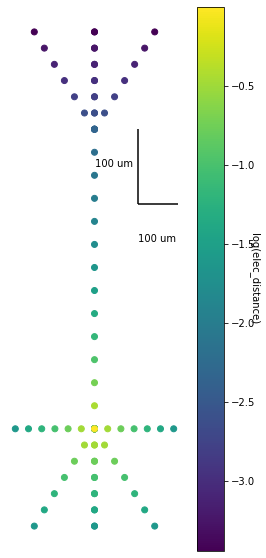

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord, c = np.log(AllSegElecDist) )
plt.vlines(110,300,400)
plt.text(0,350,'100 um')
plt.hlines(300,110,210)
plt.text(110,250,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

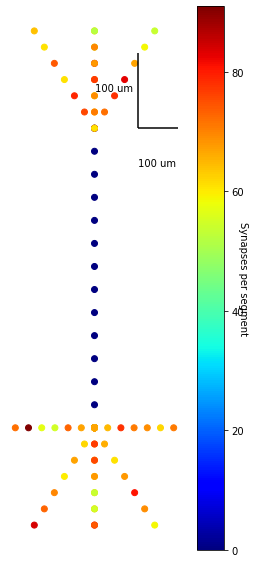

In [ ]:
plt.figure(figsize=(4,10))
ax = plt.scatter(AllSegXCoord, AllSegYCoord,c = SynPerSeg[0:98],cmap='jet')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Synapses per segment', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

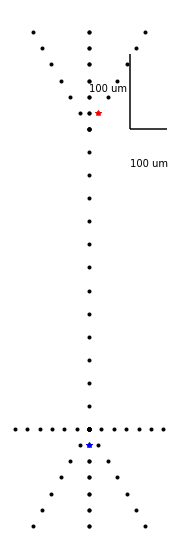

In [ ]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(AllSegXCoord[71], 
         AllSegYCoord[71],
         'r*')
plt.plot(AllSegXCoord[22], 
         AllSegYCoord[22],
         'b*')
# plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
#          segs.loc[segs.segmentID==1046,'Coord Y'],
#          'm*')
# plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
#          segs.loc[segs.segmentID==1500,'Coord Y'],
#          'g*')
# plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
#          segs.loc[segs.segmentID==680,'Coord Y'],
#          '*',color='orange')
# plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
#          segs.loc[segs.segmentID==482,'Coord Y'],
#          '*',color='grey')
# plt.savefig('fig1A.svg')

([], <a list of 0 Text major ticklabel objects>)

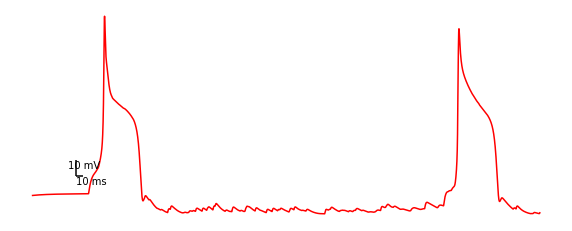

In [ ]:
v_dend = dend_v.as_numpy()

plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,2000.1,.1),v_dend[75],color='r')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

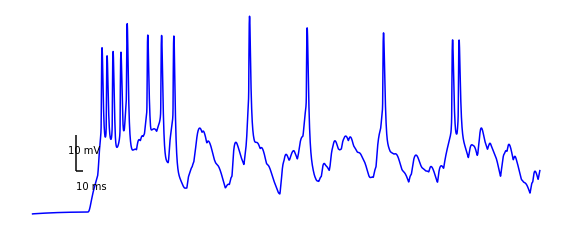

In [ ]:
v_dend = dend_v.as_numpy()

plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,2000.1,.1),v_dend[25],color='b')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

The value after the section indicates the poroportional distance along the segment. 1 being distal from the soma and 0 being proximal to the soma.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#v_dend = dend_v.as_numpy()

plt.figure(figsize=(20,14))
for i in range(v_dend.shape[0]):
    plt.plot(t,v_dend[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('Vm')
    plt.xlabel('ms')
plt.show()

In [ ]:
import h5py

# Voltage output


try:
  os.remove("v_report.hdf5")
except:
  x = 1

f1 = h5py.File("v_report.hdf5", "w")

voltage = f1.create_dataset("v", data= v_dend)
time = f1.create_dataset("t", data = t)

f1.close()

In [ ]:

try:
  os.remove("i_nmda_report.hdf5")
except:
  x = 1
  
f2 = h5py.File("i_nmda_report.hdf5", "w")

i_NMDA = f2.create_dataset("i_nmda", data = i_NMDA_bySeg)

f2.close()



